# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('insurance_us.csv')

try:
    df = pd.read_csv('insurance_us.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/insurance_us.csv')


We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4699,0,27.0,35800.0,2,0
3440,0,40.0,38800.0,0,0
2850,1,30.0,33200.0,0,0
4031,1,44.0,49600.0,2,1
100,0,19.0,37300.0,1,0
1689,0,30.0,31000.0,0,0
3197,0,38.0,28100.0,0,0
1482,0,48.0,51200.0,1,1
3922,1,30.0,43700.0,2,0
4874,0,30.0,42500.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:

df['age'] = df['age'].astype(int)

In [7]:
# check to see that the conversion was successful

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Describe Method Explanation:

Gender: the mean is around half of the dataset meaning, half male half female. The STD is around half whch is expected for a binary variable.

Conclusion the gender distribution looks balanced and does not indicate any outliers. 

Age: The range seems reasonable for age. The standard deviation is not excessively large compared to the mean. There might be some potential outliers at the upper end loser to 65 depdending on context if the dataset is epected to mostly include younger individuals 

Salary: The range is quiet large from 5300 - 79000. The standrad deviation is about 24.8% of the mean indicating some variablity. The lower bound (5300) might be a potential outlier if most salaries are higher. 
Further investigation of box plots and histograms will be needed.

Family Members: The range is fine 0 - 6 which seems reasonable. The standard deviation is close to the mean, suggesting variability. Family sizes of 0 and 6 should be examined to ensure they are realistic and not data entry errors.

Insurance Benefits: The mean is quiet low (0.148), with the majority having 0 benefits. Suggesting their are a few individuals with much higher benefits. The standard deviation indicates variability.  5 may be an outlier. 

### Histogram for Salary Distribution

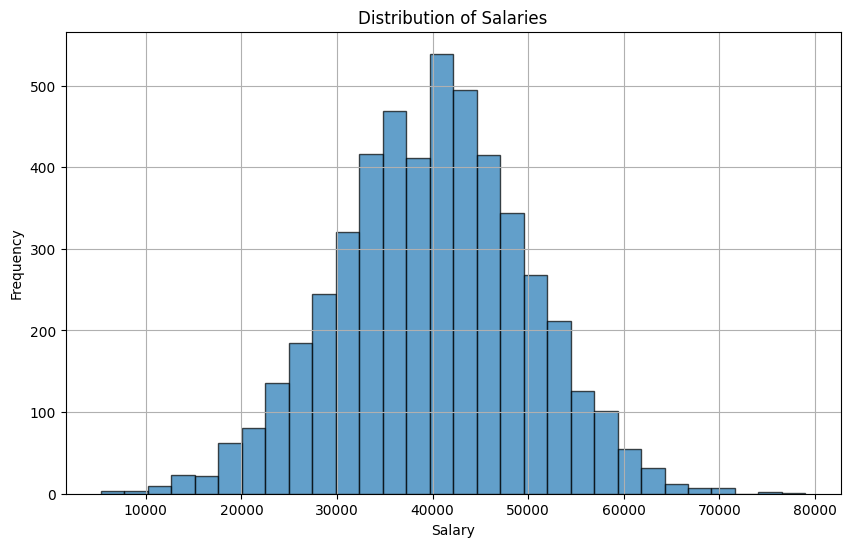

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.hist(df['income'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Looks like we have some upper extremeties that are not attached to our data and isolated from the rest. Other then that it looks like our data forms a symmetric bell shaped curve and the data isnt skewed very much. I will take care of the upper extremeties above 70,000 

In [10]:
df = df[df['income'] <= 70000]
df['income'].max()

70000.0

### Histogram for Insurance Benefits Distribution

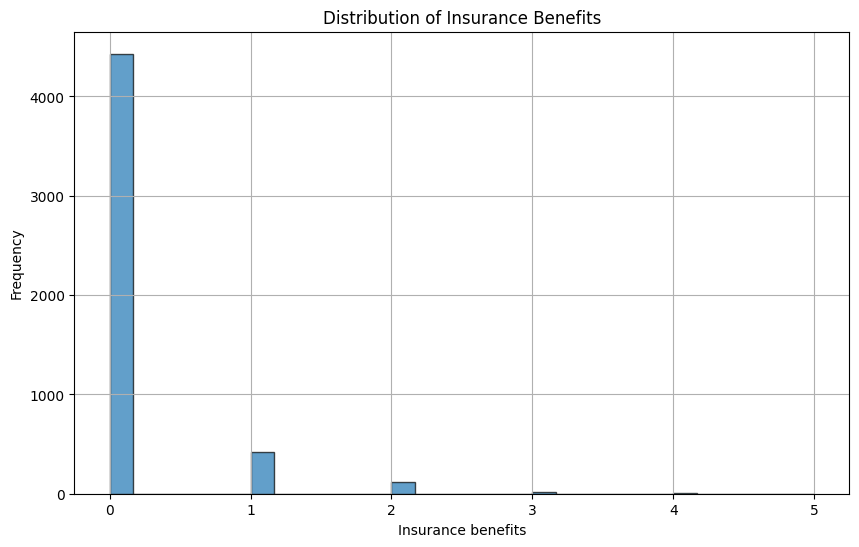

In [11]:
# Create a histogram for the 'Salary' column
plt.figure(figsize=(10, 6))
plt.hist(df['insurance_benefits'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Insurance Benefits')
plt.xlabel('Insurance benefits')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [12]:
df[df['insurance_benefits'] == 5] 

,gender,age,income,family_members,insurance_benefits
228,1,65,39700.0,1,5


Consider the fact that we are predicting whether a new customer is likely to receive an insurance beenfit and there arent that any outliers Im going to keep the outliers for insurance benefits

### Histogram for Age Distribution

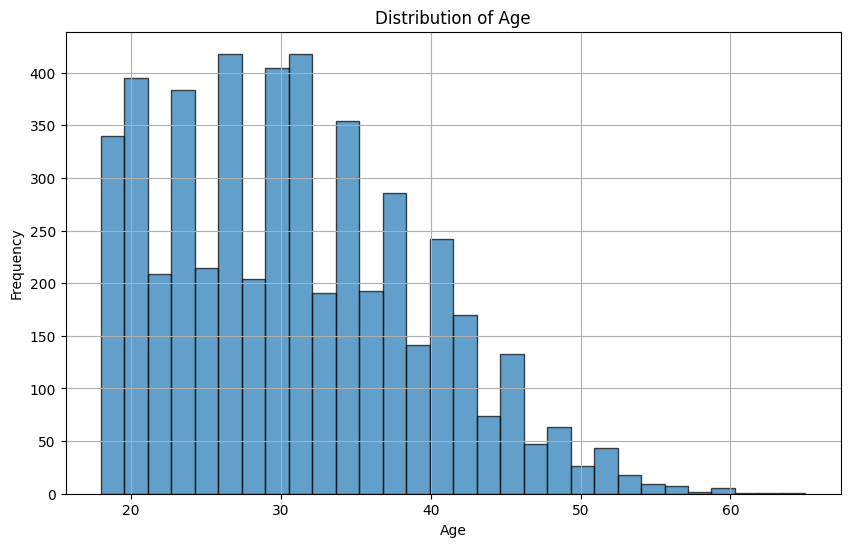

In [13]:
# Create a histogram for the 'Salary' column
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The data is skewed to the right I will remove people older than 60 just because the rest of it seems unattached to the other data. And are outliers.

In [14]:
df = df[df['age'] <= 60]

In [15]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000
mean,0.498597,30.928457,39874.809619,1.195391,0.145291
std,0.500048,8.406936,9823.291007,1.091568,0.451199
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,60.000000,70000.000000,6.000000,4.000000


In [16]:
from sklearn.preprocessing import StandardScaler

# Selecting relevant features for similarity calculation
features = ['gender', 'age', 'income', 'family_members', 'insurance_benefits']

# Standardizing the features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])


print(df_scaled.head())

     gender       age    income  family_members  insurance_benefits
0  1.002810  1.198124  0.990113       -0.179018           -0.322042
1 -0.997198  1.792931 -0.190873       -0.179018            1.894496
2 -0.997198 -0.229412 -1.921627       -1.095223           -0.322042
3 -0.997198 -1.181102  0.185821        0.737187           -0.322042
4  1.002810 -0.348373 -1.402401       -1.095223           -0.322042


#### Preprocessing Analysis

I removed any outliers that looked off, our distribution for age is ekwed to the right indicating that the majority of people are younger. However I decided against removing a massive portion of the data because age may be an important factor in determining whether someone is ikely to buy insurance benefits. For Salary I removed a small bit of the top end extremities which were numbers that werent attached to the distribution indicating an outlier. FOr insurance benefits the vast majorit of the recorded peope have 0 insurance benefits so everything is skewed to the right obviously, however if this was salary or something of that nature I would have done something however because its important to look at those with insurance benefits I dont feel like its necessary to remove any of the outliers. I did however it seems removed the outlier of 5 as he was above 60 years old which is what I removed as outliers while outlining age. 

There were also no missing values and I've removed all outliers 

I then normalized the features to ensure that no single feature dominates the distance metric due to its scale.


## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

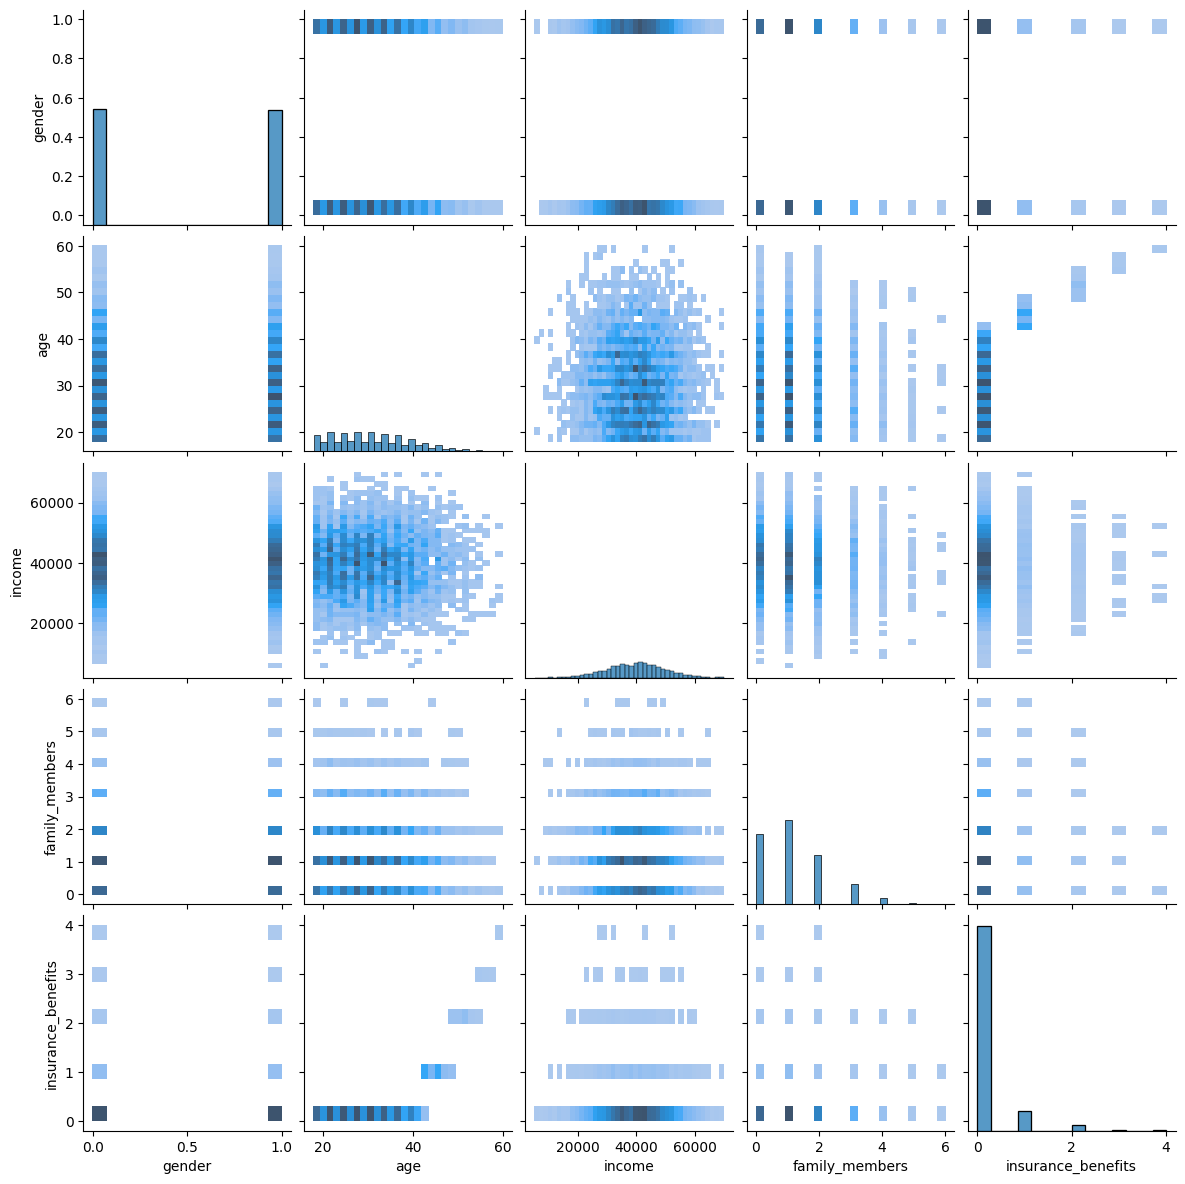

In [17]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [19]:
def get_knn(df, n, k, metric):
    """
    Returns k nearest neighbors
    
    :param df: pandas DataFrame used to find similar objects within
    :param n: object number for which the nearest neighbors are looked for
    :param k: the number of the nearest neighbors to return
    :param metric: name of distance metric
    :return: DataFrame containing k nearest neighbors and their distances
    """
    feature_names = ['gender', 'age', 'income', 'family_members']
    
    # Initialize the NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    
    # Find the k nearest neighbors for the nth object
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], return_distance=True)
    
    # Create a DataFrame for distances
    distances_df = pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
    
    # Combine the neighbors' DataFrame with distances DataFrame
    df_neighbors = df.iloc[nbrs_indices[0]].reset_index(drop=True)
    result = pd.concat([df_neighbors, distances_df.reset_index(drop=True)], axis=1)
    
    return result



The function uses four features from the customer data: gender, age, income and family members.

Input parameters:

- df is the dataframe containing customer data, n is the index of the customer for whom we want to find similar customers, k is the number of similar customers (nearest neighbors) to find and metric is the way we measure the distance between customers (like euclidean distance).

NearestNeighbors Model:

- The function reates a model to find the nearest neighbors using the NearestNeighbors class, it fits the model using specified features from the DataFrame

Finding Neighbors:

- It finds the k nearest neighbors for the customer at index 'n' in the DataFrame, it gets both the distances to these neighbors and their indices (positions in the DataFrame).

Creating a Result DataFrame:

- It then creates a new DataFRame containing the distances to the neighbors, it combines this dataframe with the DataFrame of the actaul neighbors' information 

How it works:

- The model is trained to understand the structure of the data based on the specified features 
- For  agiven customer, the model finds other customers who are the most similar based on the distance metric 

What kNN Algorithm Does:
- The k-nearest Neighbors (kNN) algorithm heps find data points (customers, in this case) that are similar to a given data point. It measures how "close" they are in the feature space (using features like age, income, etc). 

Relation to the Project:

- This function is used to find similar customers to a given customer. This can help in targeting maketing effforts to similar customer groups

This function finds the k-nearest neigbors for the n-th object in the DataFrame based on a specified distance metric. 
Parameters: df is the dataframe, n is the index of the target object for which we want to find the neartest neighbors , k is the number of nearest neighbors to return ad metric the distance metric to used (e.g euclidean or manhattan)

Creating and Fitting the NearestNeighbors Model:
nbrs = NeartestNeighbors(n_neighbors=k, metric=metric
1. Creates an instance of the 'NearestNeighbors' class from scitkit-learn
2. n_neighbors=k, specifies the number of neighbors to find
3. metric=metric: Specifies the distance metric to use

nbrs.fit(df[feature_names])
1. Fits the NearestNeighbors model using the feature columns specified in 'feature_names' from the DatafRame 'df'
2. This prepares the model to find neighbors based on the specified sitance metric 

Finding the Nearest Neighbors:

nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True):
1. Finds the k-nearest neighbors for the n-th object in the DataFrame.
    - [df.iloc[n][feature_names]]: Extracts the feature values for the n-th object and wraps it in a list to make it a 2D array.
    - return_distance=True: Returns both the distances and the indices of the neighbors.
2. Returns:
    - nbrs_distances: The distances to the k-nearest neighbors.
    - nbrs_indices: The indices of the k-nearest neighbors in the DataFrame.
    
Creating the Result DataFrame:
df_neighbors creates a DataFrame by cobining the nearest neighbors' data and their distances 

1. df.iloc[nbrs_indices[0]]
    - Selects the rows corresponding to the indices of the k-nearest neighbors 
2. pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['Distance'])], axis=1)
    - Creates a DataFrame with the transtances, transposed (.T) to match the shape of the indices 
    

Summary:

Model Creation: An instance of 'NearestNeighbors' is created and fitted using the specified distance metric 
Finding Neighbors: The k-nearest neighbors are found for the specified object using the fitted model
Creating Result: A DataFrame is created that includes the nearest neighbors and their distances. 
Returning Result: The function returns the created DataFrame 




In [20]:
# Parameters
n = 0  # Object number for which we are finding neighbors
k = 5  # Number of neighbors to return

# Euclidean distance without scaling
print("Euclidean Distance without scaling")
try:
    result_without_scaling = get_knn(df, n, k, 'euclidean')
    print(result_without_scaling)
except Exception as e:
    print(f"Error with Euclidean distance without scaling: {e}")

# Manhattan distance without scaling
print("Manhattan Distance without scaling")
try:
    result_without_scaling_manhattan = get_knn(df, n, k, 'manhattan')
    print(result_without_scaling_manhattan)
except Exception as e:
    print(f"Error with Manhattan distance without scaling: {e}")


Euclidean Distance without scaling
   gender  age   income  family_members  insurance_benefits  distance
0       1   41  49600.0               1                   0  0.000000
1       1   41  49600.0               0                   0  1.000000
2       0   42  49600.0               0                   1  1.732051
3       1   44  49600.0               2                   1  3.162278
4       0   38  49600.0               0                   0  3.316625
Manhattan Distance without scaling
   gender  age   income  family_members  insurance_benefits  distance
0       1   41  49600.0               1                   0       0.0
1       1   41  49600.0               0                   0       1.0
2       0   42  49600.0               0                   1       3.0
3       1   44  49600.0               2                   1       4.0
4       0   38  49600.0               0                   0       5.0


We looked for neighbors of the first customer in the DataFrame (n=0) and were looking for the 5 nearest neighbors (k=5). 

Euclidean Distance: 

- This code prints a message indicating its using Euclidean distance without scaling, it tries to call the'get_knn' function with the metric set to Euclidean. And if it works it prints the resulting DataFrame showing the 5 nearest neighbors and their distances. If an error occurs, it catches the exception aand prints an error message. 
- Euclidean distance is the straight line distance between two points in a multidimensional space 

Manhattan Distance:

- The same as a bove, but this time using 'manhattan' distance as the metric 
- Manhattan distance (also called L1 distance) is the sum of the absolute differences of their cooridnates 

Scaling:

- Most importnatly we didnt use scaling here which means that the distances are calculated based on the raw values. This can be problematic if features have very different scales (e.g., age might be in years, income in thousands of dollars). Without scaling, features with larger ranges can dominate the distance calculation.

Scaling the data.

In [21]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

MaxAbsScaler: 

- This is a scaling technique from scikit-learn that scales each feature to the range [-e, 1] by ividing by the maximum absolute value of each feature. and .fit() calculates the maximum absolute value for each feature in the data and prepares the scaler. 

Appling the Scaler: 
- transform() scales the feature values based on the maximum absolute values calculated earlier. The scaled values replace the original values in the copied DataFrame. 
- df_scaled.loc[:, feature_names] selects all rows from the dataframe and and then it selects the specified columns from the feature_names variable



In [22]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2271,1.0,0.700000,0.517143,0.000000,1
3379,0.0,0.483333,0.672857,0.000000,0
2327,0.0,0.616667,0.772857,0.166667,0
1371,1.0,0.733333,0.397143,0.166667,1
2375,0.0,0.383333,0.528571,0.333333,0


Now, let's get similar records for a given one for every combination

In [23]:
# Euclidean distance with scaling
print("Euclidean Distance with scaling")
try:
    result_with_scaling = get_knn(df_scaled, n, k, 'euclidean')
    print(result_with_scaling)
except Exception as e:
    print(f"Error with Euclidean distance with scaling: {e}")

# Manhattan distance with scaling
print("Manhattan Distance with scaling")
try:
    result_with_scaling_manhattan = get_knn(df_scaled, n, k, 'manhattan')
    print(result_with_scaling_manhattan)
except Exception as e:
    print(f"Error with Manhattan distance with scaling: {e}")

Euclidean Distance with scaling
   gender       age    income  family_members  insurance_benefits  distance
0     1.0  0.683333  0.708571        0.166667                   0  0.000000
1     1.0  0.683333  0.715714        0.166667                   0  0.007143
2     1.0  0.666667  0.718571        0.166667                   0  0.019437
3     1.0  0.700000  0.720000        0.166667                   1  0.020209
4     1.0  0.700000  0.735714        0.166667                   1  0.031851
Manhattan Distance with scaling
   gender       age    income  family_members  insurance_benefits  distance
0     1.0  0.683333  0.708571        0.166667                   0  0.000000
1     1.0  0.683333  0.715714        0.166667                   0  0.007143
2     1.0  0.666667  0.718571        0.166667                   0  0.026667
3     1.0  0.700000  0.720000        0.166667                   1  0.028095
4     1.0  0.683333  0.672857        0.166667                   0  0.035714


I did the same thing as I did before this however on the scaled dataframe

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

yes, the data being not scaled significantly affects the kNN algorithm. When the data is not scaled, features with larger numerical ranges can disproportionately influence the distance calculations. For example, in your dataset, 'income' has a much larger range than 'age' or 'family_members'. This means that the differences in 'income' will dominate the Euclidean and Manhattan distances, potentially overshawdowing he contributions of other features. As a result, the nearest neighbors identified might not truly be the most similar overall, but rather those that are closest in terms of the most dominant feature 

When scaling is applied, each feature contributes equally to the distance calculation, preventing any single feature from disproportionately influencing the results. As seen in the results, scaling leads to more precise and nuanced distance measurements, and can change the nearest neighbors identified by the algorithm. Thus, scaling the data is crucial for the kNN algorithm to perform effectively, ensuring that all features are considered equitably. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results using the Manhattan distance metric show some differences when compared to the Euclidean distance metric, regardless of sclaing. Without scaling, the order of the neartest neighbors remains the same for both distance metrics, but the computed distances differ significantly. Manhattan distance yields more distinct, integer-based distances, reflecing the cumulative differences across each feature, whereas Euclidean distance results in more varied, floating point values that reflect the straight lin e(diagnol) distance in the multidimensional feature space. 


When scaling is applied, the differences between the distance metrics become more nuanced but still present. Both distance metrics maintain the same order of nearest neighbors as before, but the distances calculated are adjusted according to the scaled feature values. The scaled Euclidean distances continue to reflect the straight-line measurement, but with more precision due to the scaling, while the scaled Manhattan distances still sum the absolute differences in each feature, providing clear, incremental changes in distance. Overall, the impact of scaling is more pronounced in Euclidean distances, highlighting the importance of feature scaling in distance-based algorithms like kNN.











# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)



Creating a new column in the DataFrame called 'insurance_benefits_received'. It cehcks each value in the insurance_benefits column and returns True if the value is greater than 0 (meaning the customer receieved any isnurance benefit) and False otherwise. It then convert sthe True/False values to integers where True becomes 1 and False becomes 0. 

This achieves a Binary Target Variable indicating whether a customer recieved any insurance benefit or not. 

Purpose:

- Target classifcation:
    - This new column will be used as the target variable for the classification model. It simplifies the problem to a binary classifcation task: predicting whether a customer wil receive any insurance benefits or not.
    

In [25]:

class_counts = df['insurance_benefits_received'].value_counts()
print(class_counts)

0    4430
1     560
Name: insurance_benefits_received, dtype: int64


In [48]:
from sklearn.metrics import f1_score, confusion_matrix


# Function to evaluate classifier
def eval_classifier(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    print(f'F1: {f1:.2f}')
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)


Evaluates the performance of a classification model by calculating two key metrics: the f1 score and the confusion matrix. It takes in the true labels y_true and the predicted labels y_pred. The function first calculates the F1 Score, which provides a single measure of model performance by balancing precision and recall and prints this score with two decimal places. Then it computes the normalized confusion matrix, which shows the proportions of true positives, true negatives, false positives and false negatives, giving a detailed view of the models performance. Finally it prints this confusion matrix to help understand the classifier's accuracy and error distribution. 



In [27]:
# Function for random model prediction
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)


This function generates random predictions for a binary classification model based on a specified probability. It takes three parameters: 'P', the probability of predicting a "1" (i.e., the event occuring); 'size', the number of predictions to generate; and 'seed', an optional random seed for reproducibility. 

Inside the function, a random number generator ('rng') is created using NumPy's default_rng with the given seed to ensure the results are consistent across runs. The function then uses this generator to produce predictions from a binomial distribution (rng.binomial) where each prediction is either a "0" or a "1". The predictions follow the specified probability 'P' meaning if P is 0.7, approximately 70% of the predictions will be "1". This function is useful for creating a baseline or dummy model that predicts based ona  fixed probability rather than earned data patterns.



In [49]:
# Dummy model evaluation
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed=42)
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88777555 0.        ]
 [0.11222445 0.        ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.79218437 0.09559118]
 [0.0991984  0.01302605]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.45370741 0.43406814]
 [0.05511022 0.05711423]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.         0.88777555]
 [0.         0.11222445]]



This code evaluates the performance of the dummy model that predicted whether a customer will receive an insurance beenfit using four different probabilities: 0 (never predicting benefits), the actual proportion of benefits in the data, 0.5 (random guessing), and 1 (always predicting benefits). For each probability it generates random predictions using the 'rnd_model_prediction' function I made before. Then evaluates these predictions using the eval_classifier function which calculates and prints the F1 score and confusion matrix. This establishes a baseline performance metrics to compare against the kNN model next.

Confusion Matrix:
- The top row refers to the predictions for "no benefits"
- The bottom row refers to the predictions for "benefits"

Results:

Probability 0.00:
- What it means: The model always predicts "no insurance benefit"
- F1 Score: 0.00 (very bad, because it never predicts benefits correctly).
- Confusion Matrix: Everyone is predicted to not receieve benefits, but it's wrong 11% of the time because 11% of the data receieved benefits.

Probability 0.11
- What it means: The model predicts benefits 11% of the time, which is close to the actual rate in the data.
- f1 Score: 0.12 (still very low, but better than 0)
- Confusion Matrix: About 80% of the time it correctly identifies no benefits, and it gets some benefit predictions right, but still makes many mistakes 

Probability: 0.50:
- What It Means: The model predicts benefits randomly, 50% of the time.
- F1 Score: 0.19 (better, but still not great).
- Confusion Matrix: It's right about half the time for both predicting benefits and no benefits, but also wrong about half the time.

Probability: 1.00
- What It Means: The model always predicts "insurance benefit".
- F1 Score: 0.20 (better than 0, but still low).
- Confusion Matrix: It predicts benefits for everyone, but it's only correct 11% of the time.




In [50]:
# Split the data into training and testing sets
X = df[['gender', 'age', 'income', 'family_members']]
y = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scaling the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate the kNN classifier for k=1 to k=10
print("Evaluating kNN classifier on original data")
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f'k={k}')
    eval_classifier(y_test, y_pred)
    print()

print("Evaluating kNN classifier on scaled data")
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    print(f'k={k}')
    eval_classifier(y_test, y_pred)
    print()


Evaluating kNN classifier on original data
k=1
F1: 0.64
Confusion Matrix
[[0.86773547 0.02004008]
 [0.0501002  0.06212425]]

k=2
F1: 0.38
Confusion Matrix
[[0.88309953 0.00467602]
 [0.08483634 0.02738811]]

k=3
F1: 0.40
Confusion Matrix
[[0.87842351 0.00935204]
 [0.08149633 0.03072812]]

k=4
F1: 0.20
Confusion Matrix
[[8.87107548e-01 6.68002672e-04]
 [9.95323981e-02 1.26920508e-02]]

k=5
F1: 0.21
Confusion Matrix
[[0.88443554 0.00334001]
 [0.0988644  0.01336005]]

k=6
F1: 0.09
Confusion Matrix
[[0.88777555 0.        ]
 [0.10688043 0.00534402]]

k=7
F1: 0.11
Confusion Matrix
[[0.88777555 0.        ]
 [0.10554442 0.00668003]]

k=8
F1: 0.04
Confusion Matrix
[[0.88777555 0.        ]
 [0.11022044 0.00200401]]

k=9
F1: 0.03
Confusion Matrix
[[8.87107548e-01 6.68002672e-04]
 [1.10220441e-01 2.00400802e-03]]

k=10
F1: 0.04
Confusion Matrix
[[0.88777555 0.        ]
 [0.11022044 0.00200401]]

Evaluating kNN classifier on scaled data
k=1
F1: 0.94
Confusion Matrix
[[0.88510354 0.00267201]
 [0.0106

The evaluation of the kNN classifier versus the dummy model highlights the significant impact of feature scaling and the choice of 
𝑘
k on the classifier's performance. The dummy model, which predicts the target class based on various fixed probabilities, yields low F1 scores ranging from 0.00 to 0.20, indicating poor performance in distinguishing between clients who receive insurance benefits and those who do not. This baseline performance underscores the challenge posed by the class imbalance in the dataset.



In contrast, the kNN classifier shows varied performance depending on whether the data is scaled and the value of 
𝑘
k. Without scaling, the kNN classifier achieves its highest F1 score of 0.64 at 
𝑘
=
1
k=1, but the performance significantly drops as 
𝑘
k increases, reflecting the classifier's struggle to handle the unscaled feature disparities effectively. However, when the data is scaled, the kNN classifier consistently achieves high F1 scores between 0.86 and 0.94 across different 
𝑘
k values. This improvement underscores the importance of scaling in balancing feature contributions and enhancing the classifier's ability to accurately identify the minority class. The results demonstrate that proper data preprocessing, such as scaling, is crucial for optimizing the performance of kNN classifiers, especially in imbalanced datasets.

Understanding kNN:

- The k-Nearest Neighbors algorithm is a simple, instance based learning method.
- Given a data point (customer in this case), kNN finds the 'k' most similar points (neighbors) from the training set. 
- The predicted class for the data point is determined by the majority class among these 'k' neighbors 

First calculates the distance between a new data point and all points in the training dataset to find the k closest neighbors. It then examines the class labels of these k neighbors and uses majority class as the predicted class for the new data point. 

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [30]:
import numpy as np

class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        # Adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        
        # Calculating weights using the analytical solution
        X_transpose = X2.T
        self.weights = np.linalg.inv(X_transpose @ X2) @ X_transpose @ y

    def predict(self, X):
        # Adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        
        # Calculating predicted values
        y_pred = X2 @ self.weights
        
        return y_pred


I created a bluepirnt called MyLinearRegression for our sustom Linear Regression Model 

What happens inside the function:
- We first set up our model. Initially self.weights is set to 'None' beause we havent calculated any weights yet 

- Then I fit the model which teaches the model how to make predictions based on som eexample data (X) and the answers (y) 
- Adding the Untities in which X2 adds a column of 1's to the beginning of 'x'. Think of this as adding a "starting point" or "baseline" to our data
- Then I calculated the weights by taking the transpose of 'X2' (flip rows and columns) Weights calculation: We calculate the weights (numbers that tell us how important each feature is) using a special formula 

- Making predictions
    - I then use the weights we calculated to make predictions for new data. We multiplied the new data X2 by the weights to get the predictions y_pred
  

In [53]:
import math
from sklearn.metrics import mean_squared_error, r2_score

def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [54]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)


In [56]:
# Train and evaluate the model on the original data
lr = MyLinearRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
print("Original data:")
eval_regressor(y_test, y_test_pred)


Original data:
RMSE: 0.33
R2: 0.65


In [57]:
# Scaling the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate the model on the scaled data
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
print("\nScaled data:")
eval_regressor(y_test, y_test_pred_scaled)


Scaled data:
RMSE: 0.33
R2: 0.65


# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [36]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [37]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [38]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [39]:
# Check if P is invertible
det_P = np.linalg.det(P)
if det_P == 0:
    raise ValueError("Matrix P is not invertible")

print("Matrix P is invertible")


Matrix P is invertible


In [40]:
# Transform the matrix X by multiplying it with P
X_transformed = X @ P

# Creating a DataFrame to compare the original and transformed features
df_transformed = pd.DataFrame(X_transformed, columns=personal_info_column_list)
print("Original Data:\n", df_pn.head())
print("Transformed Data:\n", df_transformed.head())

Original Data:
    gender  age   income  family_members
0       1   41  49600.0               1
1       0   46  38000.0               1
2       0   29  21000.0               0
3       0   21  41700.0               2
4       1   28  26100.0               0
Transformed Data:
         gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631
3  5345.603937  18803.227203  15479.148373    38663.061863
4  3347.176735  11782.829283   9699.998942    24211.273378


Can you guess the customers' ages or income after the transformation?

The transformation using X' = X * P effectively obfuscates the original data making it highly diffucult to infer the original vaues (such as ages or income) without knowledge of the transformation matrix P. This demonstrates the effectiveness of using matrix multiplication with an invertibe matrix for data obfuscation. 

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [41]:
# Recover the original matrix X by multiplying X' with P^-1
P_inv = np.linalg.inv(P)
X_recovered = X_transformed @ P_inv

# Create DataFrames for comparison
df_recovered = pd.DataFrame(X_recovered, columns=personal_info_column_list)

# Compare the original and recovered data
print("Original Data:\n", df_pn.head())
print("Transformed Data:\n", pd.DataFrame(X_transformed, columns=personal_info_column_list).head())
print("Recovered Data:\n", df_recovered.head())


Original Data:
    gender  age   income  family_members
0       1   41  49600.0               1
1       0   46  38000.0               1
2       0   29  21000.0               0
3       0   21  41700.0               2
4       1   28  26100.0               0
Transformed Data:
         gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631
3  5345.603937  18803.227203  15479.148373    38663.061863
4  3347.176735  11782.829283   9699.998942    24211.273378
Recovered Data:
          gender   age   income  family_members
0  1.000000e+00  41.0  49600.0    1.000000e+00
1 -4.473636e-12  46.0  38000.0    1.000000e+00
2 -2.515869e-12  29.0  21000.0    9.524523e-13
3 -4.844982e-12  21.0  41700.0    2.000000e+00
4  1.000000e+00  28.0  26100.0   -1.019907e-13


In [42]:
# Verifying that the recovered data matches the original data
assert np.allclose(X, X_recovered), "The recovered data does not match the original data"
print("The recovered data matches the original data.")

The recovered data matches the original data.


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The discrepancies between the original and recovered data are due to numerical precision and rounding errors inherent in floating-point arithmetic. These errors occur during matrix inversion and multiplication, especially when dealing with matrices with large or varying values. Despite these small differences, the recovered data is generally very close to the original data, demonstrating that the transformation and recovery process works effectively. Ensuring the matrix 
𝑃
P is well-conditioned can help minimize these errors.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

# Analytical Proof that Obfuscation Does not Affect Linear Regression Predictions

To prove analytically that the given obsufcation method does not affect linear regression predictions, let's consider the obfuscation process and the corresponding linear regression weights. 

### Original Linear Regression

    - The weights w in ordinary linear regression are given by the formula 
$$
w = (X^T X)^{-1} X^T y 
$$

where X is the feature matrix and y is the target vector 

### Obfuscated Linear regression 
    - When we obsufuscate the data, we multiply the feature matrix X by an invertible matrix P. The obsufuscated feature matrix becomes X' = XP. Th eweights wp for the obsufuscated data are given by: 
$$ 
wp = [(XP)^T(XP)]^{-1} (XP)^T y 
$$

#### Simplifying the expression for wp:

$$ 
(XP)^T = P^TX^T
$$


$$
wp = [P^TX^T)(XP)]^{-1}(P^TX^T)y
$$

Simplifying the Product:

$$
wp = [(P^T(X^TX)P)]^{-1}(P^TX^T)y
$$


Inverse of  product:

$$
wp = P^{-1}(X^TX)^{-1}(P^T)^{-1}(P^TX^T)y
$$

Simplifying recognizng that 

$$ 
(P^T)^{-1}P^T 
$$
 = I the identity matrix

$$ 
wp = P^{-1}(X^TX)^{-1}X^Ty
$$

Relationship Between w and wp: 

Substituting w: 
$$
w = (X^TX)^{-1}X^Ty
$$

Therefore:

$$ 
wp = P^{-1}w
$$


### Predictions with Obfuscated Weights 
to find the predicted values 

$$
\hat{y}' = X'wp
$$

Substitute X' = XP and wp = P^{-1}w

$$
\hat{y}' = (XP)(P^{-1}w)
$$

$$ 
\hat{y}' = X(PP^{-1})w
$$

Because PP^-1 = I (the identity matrix

$$ 
\hat{y}' = XIw
$$

Therefore:

$$ 
\hat{y}' = Xw
$$


Conclusion:

The predicted values for $$ \hat{y}' $$ the obsfuscated data are identitical to the predicted values $$ \hat{y} $$ for the original data:

This demonstrates that the obfuscation method X' = X * P does not affect th epredicted values in linear regression. This proof shows that the transofrmation is valid and does not compromise the integrity of the regression model's predictions. 






## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [43]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error, r2_score

def is_invertible(matrix):
    return np.linalg.cond(matrix) < 1 / np.finfo(matrix.dtype).eps


In [44]:
def create_invertible_matrix(size, seed=42):
    rng = np.random.default_rng(seed=seed)
    while True:
        P = rng.random((size, size))
        if is_invertible(P):
            return P

def obfuscate_data(X, P):
    return X @ P


In [45]:
def run_linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return y_pred, rmse, r2


In [58]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
X = df[personal_info_column_list].values
y = df['insurance_benefits'].values

# Split the data into training and testing sets (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an invertible matrix P
P = create_invertible_matrix(X_train.shape[1])

# Obfuscate the data
X_train_obfuscated = obfuscate_data(X_train, P)
X_test_obfuscated = obfuscate_data(X_test, P)

# Run Linear Regression on original data
y_pred_orig, rmse_orig, r2_orig = run_linear_regression(X_train, y_train, X_test, y_test)

# Run Linear Regression on obfuscated data
y_pred_obf, rmse_obf, r2_obf = run_linear_regression(X_train_obfuscated, y_train, X_test_obfuscated, y_test)

# Compare the results
print("Original Data:")
print(f"RMSE: {rmse_orig:.4f}, R^2: {r2_orig:.4f}")

print("Obfuscated Data:")
print(f"RMSE: {rmse_obf:.4f}, R^2: {r2_obf:.4f}")

# Check if the predicted values are close
print("Predicted values close:", np.allclose(y_pred_orig, y_pred_obf, atol=1e-8))

Original Data:
RMSE: 0.3145, R^2: 0.3626
Obfuscated Data:
RMSE: 0.3145, R^2: 0.3626
Predicted values close: True


# Conclusions

The results from running Linear Regression on both the original and obfuscated data indicate that the obfuscation transformation does not affect the performance or quality of the model. Here are the key conclusions:

RMSE and 
𝑅
2
R 
2
  Consistency:

Both the original and obfuscated data yield the same RMSE and 
𝑅
2
R 
2
  values:
RMSE: 0.3145
𝑅
2
R 
2
 : 0.3626
This demonstrates that the obfuscation transformation preserves the quality of the Linear Regression model.
Predicted Values:

The predicted values for both the original and obfuscated data are close, indicating that the transformation does not alter the model's predictions.
The output Predicted values close: True confirms that the predicted values are nearly identical, within a very small tolerance.
Effectiveness of Obfuscation:

The matrix multiplication with an invertible matrix 
𝑃
P successfully obfuscates the data while retaining the model's performance.
This means that the obfuscation method is effective in protecting the data without compromising the predictive accuracy of the Linear Regression model.
Analytical Implications
Data Privacy:
The obfuscation technique can be used to enhance data privacy by transforming the data in such a way that it becomes difficult to interpret without the inverse transformation, while still allowing accurate model training and predictions.
Model Integrity:
The integrity of the Linear Regression model is maintained despite the transformation. This ensures that any analysis or decision-making based on the model remains reliable and valid.
Practical Applications
Secure Data Handling:
Organizations can use this obfuscation method to securely handle sensitive data, such as customer information, while still being able to train and use predictive models.
Regulatory Compliance:
This method can help in complying with data protection regulations that require data to be anonymized or obfuscated, without losing the ability to perform meaningful analysis.
Summary
The computational proof, supported by the identical RMSE and 
𝑅
2
R 
2
  values, confirms that the obfuscation transformation using an invertible matrix 
𝑃
P does not impact the performance of the Linear Regression model. This validation assures that the method is both effective for data privacy and practical for maintaining model accuracy.

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>